# Traits prediction in Tsetse flies using restricted number of wavenumbers
Final jupyter notebook for sex, and age prediction of males and females flies using the infrared region from 1750-602 cm $^{-1}$. This notebooks creates the models and reproduces figure 5 and figure S3 of the manuscript. 

## Changelog
### 16/11/2023
Added extraction of top20 wavenumbers plot

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import packages

import sys

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import joblib


from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score



sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import model_optimization
from utilities import train_model
from utilities import test_model
from utilities import variable_importance_df
from utilities import add_label_band
from utilities import montecarlo_crossvalidation

In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/processed/TseTse_processed.csv")
#tsetse_data = pd.read_csv("../data/processed/TseTse_processed_wo_outliers.csv")

In [5]:
df_ic = pd.DataFrame(tsetse_data.groupby(['Sex','Age','Tissue'])['ID'].count())
df_ic

ID
Sex Age Tissue      
f   3d  Abdomen   48
        Head     133
        Thorax   136
    5w  Abdomen   16
        Head      92
        Thorax    96
    7w  Abdomen   38
        Head     120
        Thorax   122
m   5w  Head      94
        Thorax    93
    7w  Abdomen   15
        Head      93
        Thorax    92

In [6]:
tsetse_data_sameages = tsetse_data[(tsetse_data["Age"]!= '3d')]
tsetse_data_sameages_copy = tsetse_data_sameages.copy()

tsetse_thorax = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Thorax']
tsetse_head = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Head']

## Sex prediction

In [7]:
X_sex_thorax = tsetse_thorax.loc[:,"1750":"602"]
y_sex_thorax = tsetse_thorax.loc[:,"Sex"]

X_sex_head = tsetse_head.loc[:,"1750":"602"]
y_sex_head = tsetse_head.loc[:,"Sex"]

In [8]:
waveNumslist = X_sex_thorax.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [9]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_sex_thorax, y_sex_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_sex_head, y_sex_head, test_size=0.2, shuffle=True, random_state=123)

In [61]:
sex_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
sex_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [62]:
sex_data_plot_thorax = dataplotmelt(sex_thorax_acc_baseline)
sex_data_plot_head = dataplotmelt(sex_head_acc_baseline)

In [63]:
# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)
# thorax
best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [64]:
# Train the best model
sex_model_head=train_model(X_hd_train,y_hd_train, best_model_head,'sex_head_informative')
sex_model_thorax=train_model(X_th_train,y_th_train, best_mdoel_thorax,'sex_thorax_informative')

In [10]:
#test model
loaded_model_sex_head = joblib.load('../results/models/trained_model_sex_head_informative.sav')
loaded_model_sex_thorax = joblib.load('../results/models/trained_model_sex_thorax_informative.sav')

In [11]:
y_sex_head_pred = test_model(X_hd_test, y_hd_test, loaded_model_sex_head)

y_sex_thorax_pred = test_model(X_th_test, y_th_test, loaded_model_sex_thorax)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=100, max_iter=10000,
                                    solver='newton-cg'))])
Accuracy on test set using the head: 0.9625
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, max_iter=10000, solver='newton-cg'))])
Accuracy on test set using the head: 0.9012345679012346


In [67]:
#sex_data_plot_head[sex_data_plot_head['param_clf'] == 'RF']['value'].mean()
#sex_data_plot_thorax[sex_data_plot_thorax['param_clf'] == 'RF']['value'].mean()

# sex_data_plot_thorax.groupby('param_clf')['value'].mean()
# sex_data_plot_thorax.groupby('param_clf')['value'].std()

In [68]:
sex_data_plot_head.groupby('param_clf')['value'].mean()

param_clf
CART    0.898438
LR      0.935937
RF      0.925000
SVC     0.932813
Name: value, dtype: float64

## Male age prediction

In [12]:
tsetse_males_thorax = tsetse_data.loc[(tsetse_data['Sex'] == 'm') & (tsetse_data['Tissue'] == 'Thorax')]

tsetse_males_head = tsetse_data.loc[(tsetse_data['Sex'] == 'm') & (tsetse_data['Tissue'] == 'Head')]

In [13]:
X_males_thorax = tsetse_males_thorax.loc[:,"1750":"602"]
X_males_head = tsetse_males_head.loc[:,"1750":"602"]

y_males_thorax = tsetse_males_thorax.loc[:,"Age"]
y_males_head = tsetse_males_head.loc[:,"Age"]

In [14]:
Xm_th_train, Xm_th_test, ym_th_train, ym_th_test = train_test_split(X_males_thorax, y_males_thorax, test_size=0.2, shuffle=True, random_state=123)

Xm_hd_train, Xm_hd_test, ym_hd_train, ym_hd_test = train_test_split(X_males_head, y_males_head, test_size=0.2, shuffle=True, random_state=123)

In [72]:
males_thorax_acc_baseline = baseline_accuracy(Xm_th_train, ym_th_train)
males_head_acc_baseline = baseline_accuracy(Xm_hd_train,ym_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [73]:
males_data_plot_thorax = dataplotmelt(males_thorax_acc_baseline)
males_data_plot_head = dataplotmelt(males_head_acc_baseline)

In [74]:
# model optimization

males_best_model_head = model_optimization(Xm_hd_train,ym_hd_train)
males_best_model_thorax = model_optimization(Xm_th_train, ym_th_train)

Best model parameters{'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [75]:
# Train the best model
train_model(Xm_hd_train,ym_hd_train, males_best_model_head,"head_male_informative")
train_model(Xm_th_train,ym_th_train,males_best_model_thorax,"thorax_male_informative")

In [15]:
#test model
loaded_model_males_head = joblib.load('../results/models/trained_model_head_male_informative.sav')

loaded_model_males_thorax = joblib.load('../results/models/trained_model_thorax_male_informative.sav')

In [16]:
y_male_head_pred = test_model(Xm_hd_test, ym_hd_test, loaded_model_males_head)

y_male_thorax_pred = test_model(Xm_th_test, ym_th_test, loaded_model_males_thorax)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(max_iter=10000, solver='liblinear'))])
Accuracy on test set using the head: 0.9473684210526315
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=100, max_iter=10000,
                                    solver='newton-cg'))])
Accuracy on test set using the head: 0.8648648648648649


## Female age prediction

In [17]:
tsetse_females_thorax = tsetse_data.loc[(tsetse_data['Sex'] == 'f') & (tsetse_data['Tissue'] == 'Thorax')]

tsetse_females_head = tsetse_data.loc[(tsetse_data['Sex'] == 'f') & (tsetse_data['Tissue'] == 'Head')]

In [18]:
X_females_thorax = tsetse_females_thorax.loc[:,"1750":"602"]
X_females_head = tsetse_females_head.loc[:,"1750":"602"]

y_females_thorax = tsetse_females_thorax.loc[:,"Age"]
y_females_head = tsetse_females_head.loc[:,"Age"]

In [19]:
Xf_th_train, Xf_th_test, yf_th_train, yf_th_test = train_test_split(X_females_thorax, y_females_thorax, test_size=0.2, shuffle=True, random_state=123)

Xf_hd_train, Xf_hd_test, yf_hd_train, yf_hd_test = train_test_split(X_females_head, y_females_head, test_size=0.2, shuffle=True, random_state=123)

In [81]:
females_thorax_acc_baseline = baseline_accuracy(Xf_th_train, yf_th_train)
females_head_acc_baseline = baseline_accuracy(Xf_hd_train,yf_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [82]:
females_data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
females_data_plot_head = dataplotmelt(females_head_acc_baseline)

In [83]:
# model optimization

females_best_model_head = model_optimization(Xf_hd_train,yf_hd_train)
females_best_model_thorax = model_optimization(Xf_th_train, yf_th_train)

Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [84]:
# Train the best model
train_model(Xf_hd_train,yf_hd_train, females_best_model_head,"head_female_informative")
train_model(Xf_th_train,yf_th_train, females_best_model_thorax,"thorax_female_informative")

In [20]:
#test model
loaded_model_females_head = joblib.load('../results/models/trained_model_head_female_informative.sav')

loaded_model_females_thorax = joblib.load('../results/models/trained_model_thorax_female_informative.sav')

In [21]:
y_female_head_pred = test_model(Xf_hd_test, yf_hd_test, loaded_model_females_head)

y_female_thorax_pred = test_model(Xf_th_test, yf_th_test, loaded_model_females_thorax)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, max_iter=10000, solver='liblinear'))])
Accuracy on test set using the head: 0.8260869565217391
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=100, max_iter=10000,
                                    solver='liblinear'))])
Accuracy on test set using the head: 0.8732394366197183


Text(0.5, 0.34, 'Female age prediction')

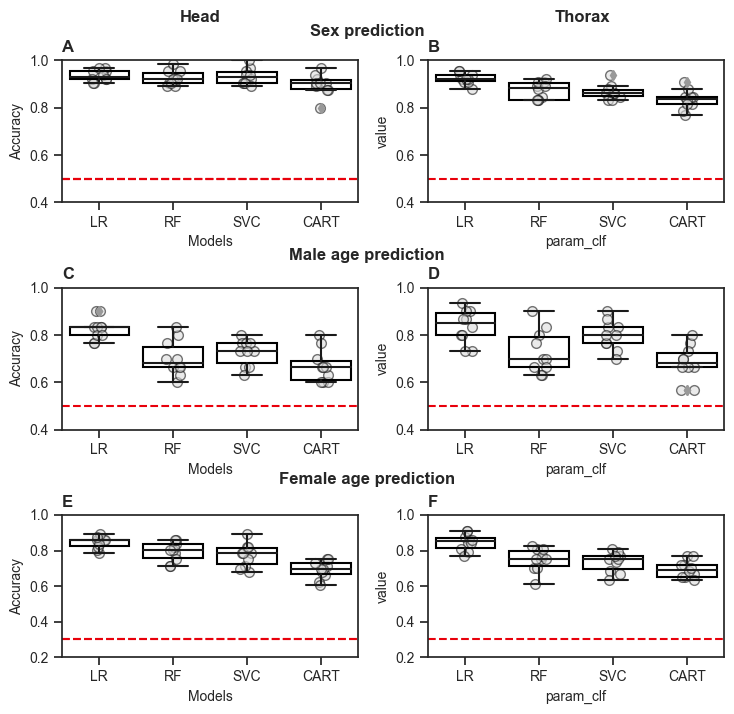

In [87]:
# Figure 4

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":10,
    'xtick.labelsize':10,
    'ytick.labelsize':10}

sn.set_style("ticks")
sn.set_context('notebook', rc=rc)
sn.set_palette('bright', color_codes=True)

fig, ((ax, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(7.5,7), tight_layout=False)

plt.subplots_adjust(hspace=0)


# Sex prediction
sn.boxplot(data=sex_data_plot_head, x='param_clf',y='value',ax=ax, color='white',boxprops={'fill': None})
sn.stripplot(data=sex_data_plot_head, x='param_clf',y='value',ax=ax,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax.lines, color='k')

for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)


sn.boxplot(data=sex_data_plot_thorax, x='param_clf',y='value',ax=ax2, color='white',boxprops={'fill': None})
sn.stripplot(data=sex_data_plot_thorax, x='param_clf',y='value',ax=ax2,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax2.lines, color='k')

for l, box in enumerate(ax2.patches):
    box.set_edgecolor('black')

ax2.axhline(0.5, color='r', ls='--')
ax2.set_ylim(0.4,1)





# Male age prediction
sn.boxplot(data=males_data_plot_thorax, x='param_clf',y='value',ax=ax4, color='white',boxprops={'fill': None})
sn.stripplot(data=males_data_plot_thorax, x='param_clf',y='value',ax=ax4,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax4.lines, color='k')
for l, box in enumerate(ax4.patches):
    box.set_edgecolor('black')

ax4.axhline(0.5, color='r', ls='--')
ax4.set_ylim(0.4,1)


sn.boxplot(data=males_data_plot_head, x='param_clf',y='value',ax=ax3, color='white',boxprops={'fill': None})
sn.stripplot(data=males_data_plot_head, x='param_clf',y='value',ax=ax3,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax3.lines, color='k')
for l, box in enumerate(ax3.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)




# female age prediction
sn.boxplot(data=females_data_plot_head, x='param_clf',y='value',ax=ax5, color='white',boxprops={'fill': None})
sn.stripplot(data=females_data_plot_head, x='param_clf',y='value',ax=ax5,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax5.lines, color='k')
for l, box in enumerate(ax5.patches):
    box.set_edgecolor('black')

ax5.axhline(0.3, color='r', ls='--')
ax5.set_ylim(0.2,1)

sn.boxplot(data=females_data_plot_thorax, x='param_clf',y='value',ax=ax6, color='white',boxprops={'fill': None})
sn.stripplot(data=females_data_plot_thorax, x='param_clf',y='value',ax=ax6,size=7,linewidth=1,edgecolor='k',color='gainsboro',zorder=0, alpha=0.6, legend=False)
plt.setp(ax6.lines, color='k')
for l, box in enumerate(ax6.patches):
    box.set_edgecolor('black')

ax6.axhline(0.3, color='r', ls='--')
ax6.set_ylim(0.2,1)






# Overall aesthetics and annotations

plots1 = [ax2,ax4,ax6]

plots_g = [ax,ax2,ax3,ax4,ax5,ax6]
abcd = ["A", "B", "C", "D", "E", "F"]

for i,a in zip(plots_g,abcd):
    i.set_title(a, fontweight='bold',loc="left")



plots2 = [ax,ax3]
for i in plots2:
    i.axhline(0.5, color='r', ls='--')
    i.set_ylim(0.4,1)
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")

ax5.axhline(0.3, color='r', ls='--')
ax5.set_ylim(0.2,1)
ax5.set_xlabel("Models")
ax5.set_ylabel("Accuracy")

fig.text(x=0.25,y=1,s="Head",fontweight='bold')
fig.text(x=0.75,y=1,s="Thorax",fontweight='bold')
fig.text(x=0.5,y=0.98,s="Sex prediction",ha='center',fontweight='bold')
fig.text(x=0.5,y=0.66,s="Male age prediction",ha='center',fontweight='bold')
fig.text(x=0.5,y=0.34,s="Female age prediction",ha='center',fontweight='bold')



#plt.savefig("../results/plots/FigS2.png", dpi=300, bbox_inches='tight')

In [23]:
variable_importance_sex_head = variable_importance_df(wavenumbers, loaded_model_sex_head)
variable_importance_males_head = variable_importance_df(wavenumbers,loaded_model_males_head)
variable_importance_females_head = variable_importance_df(wavenumbers, loaded_model_females_head)

In [24]:
variable_importance_sex_thorax = variable_importance_df(wavenumbers, loaded_model_sex_thorax)
variable_importance_males_thorax = variable_importance_df(wavenumbers,loaded_model_males_thorax)
variable_importance_females_thorax = variable_importance_df(wavenumbers, loaded_model_females_thorax)

In [92]:
wavenumbers_tsetse_important = {'sex_id_head':variable_importance_sex_head['Wavenumbers'].to_numpy(),
          'sex_id_thorax': variable_importance_sex_thorax['Wavenumbers'].to_numpy(), 
          'age_males_head': variable_importance_males_head['Wavenumbers'].to_numpy(), 
          'age_males_thorax': variable_importance_males_thorax['Wavenumbers'].to_numpy(),
          'age_females_head': variable_importance_females_head["Wavenumbers"].to_numpy(),
          'age_females_thorax': variable_importance_females_thorax['Wavenumbers'].to_numpy()}




In [58]:
df_wavenumbers_tsetse_important = pd.DataFrame(wavenumbers_tsetse_important)
df_wavenumbers_tsetse_important_sort = pd.DataFrame(np.sort(df_wavenumbers_tsetse_important.values, axis=0), index = df_wavenumbers_tsetse_important.index, columns=df_wavenumbers_tsetse_important.columns)

df_wavenumbers_tsetse_important_sort.to_csv("/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/results/tables/informative_region_results/wvn_import_sort.csv")



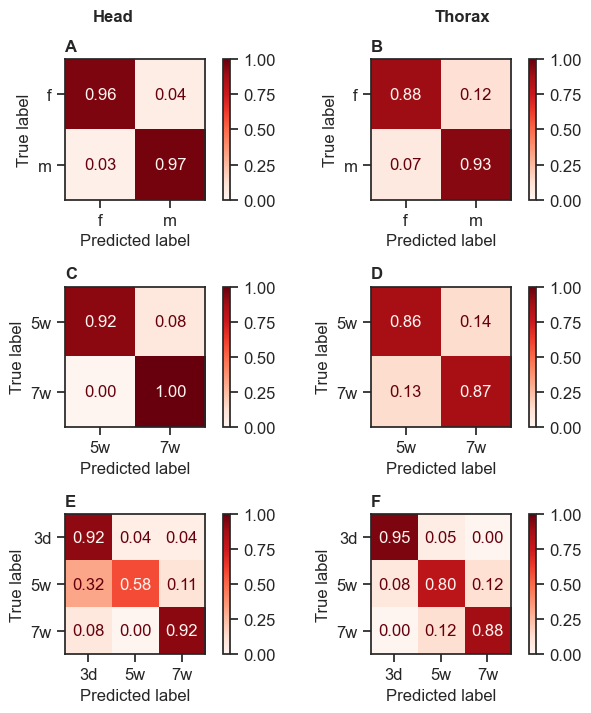

In [22]:
rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )

fig, ((ax, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2, figsize=(7,7), tight_layout=False)


# Sex
disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_sex_head_pred,display_labels=loaded_model_sex_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_sex_thorax_pred,display_labels=loaded_model_sex_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


# Age males

disp = ConfusionMatrixDisplay.from_predictions(ym_hd_test,y_male_head_pred,display_labels=loaded_model_males_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax3, im_kw={'vmin':0, 'vmax':1})

disp = ConfusionMatrixDisplay.from_predictions(ym_th_test,y_male_thorax_pred,display_labels=loaded_model_males_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


# Age females

disp = ConfusionMatrixDisplay.from_predictions(yf_hd_test,y_female_head_pred,display_labels=loaded_model_females_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax5, im_kw={'vmin':0, 'vmax':1})

disp = ConfusionMatrixDisplay.from_predictions(yf_th_test,y_female_thorax_pred,display_labels=loaded_model_females_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax6, im_kw={'vmin':0, 'vmax':1})

plots_g = [ax,ax2,ax3,ax4,ax5,ax6]
abcd = ["A", "B", "C", "D", "E", "F"]

for i,a in zip(plots_g,abcd):
    i.set_title(a, fontweight='bold',loc="left")

fig.text(0.3,1,s="Head",fontweight='bold', ha='center')
fig.text(0.8,1,s="Thorax", fontweight='bold', ha='center')

plt.savefig("../results/plots/Fig8.tiff", dpi=300,bbox_inches='tight')


In [106]:
np.shape(loaded_model_sex_head['model'].coef_[0])

(575,)

In [94]:
restricted_accuracy_training = {
    'sex_pred_mean': [sex_data_plot_head[sex_data_plot_head['param_clf'] == 'LR']['value'].mean(),
                      sex_data_plot_thorax[sex_data_plot_thorax['param_clf'] == 'LR']['value'].mean()],
    'sex_pred_std': [sex_data_plot_head[sex_data_plot_head['param_clf'] == 'LR']['value'].std(), sex_data_plot_thorax[sex_data_plot_thorax['param_clf'] == 'LR']['value'].std()],
    
    'male_pred_mean':[males_data_plot_head[males_data_plot_head['param_clf'] == 'LR']['value'].mean(),males_data_plot_thorax[males_data_plot_thorax['param_clf'] == 'LR']['value'].mean()],
                       'male_pred_std':[males_data_plot_head[males_data_plot_head['param_clf'] == 'LR']['value'].std(),males_data_plot_thorax[males_data_plot_thorax['param_clf'] == 'LR']['value'].std()],
                       'fem_pred_mean':[females_data_plot_head[females_data_plot_head['param_clf']=='LR']['value'].mean(),females_data_plot_thorax[females_data_plot_thorax['param_clf']=='LR']['value'].mean()],'fem_pred_std':[females_data_plot_head[females_data_plot_head['param_clf']=='LR']['value'].std(),females_data_plot_thorax[females_data_plot_thorax['param_clf']=='LR']['value'].std()]}

In [95]:
restricted_accuracy_test = {
    'sex':[accuracy_score(y_hd_test,y_sex_head_pred),
                accuracy_score(y_th_test,y_sex_thorax_pred)],
    'males': [accuracy_score(ym_hd_test,y_male_head_pred),
                   accuracy_score(ym_th_test,y_male_thorax_pred)],
    'females': [accuracy_score(yf_hd_test,y_female_head_pred),
                accuracy_score(yf_th_test,y_female_thorax_pred)]
}

In [96]:
restricted_acc_test_df = pd.DataFrame.from_dict(restricted_accuracy_test).T

In [97]:
restricted_acc_test_df.rename(columns={0:'Head', 1:'Thorax'}, inplace=True)

In [112]:
arrays = [['Sex','Sex','Males','Males','Females','Females'],["head", 'thorax',"head", 'thorax',"head", 'thorax']]

df2 = pd.DataFrame([
    [
        sex_data_plot_head[sex_data_plot_head['param_clf'] == 'LR']['value'].mean(),
        sex_data_plot_head[sex_data_plot_head['param_clf'] == 'LR']['value'].std(),
        accuracy_score(y_hd_test,y_sex_head_pred)],
    [
        sex_data_plot_thorax[sex_data_plot_thorax['param_clf'] == 'LR']['value'].mean(),
        sex_data_plot_thorax[sex_data_plot_thorax['param_clf'] == 'LR']['value'].std(),
        accuracy_score(y_th_test,y_sex_thorax_pred)],
    [
        males_data_plot_head[males_data_plot_head['param_clf'] == 'LR']['value'].mean(), 
        males_data_plot_head[males_data_plot_head['param_clf'] == 'LR']['value'].std(), 
        accuracy_score(ym_hd_test,y_male_head_pred)],
    [
        males_data_plot_thorax[males_data_plot_thorax['param_clf'] == 'LR']['value'].mean(), 
        males_data_plot_thorax[males_data_plot_thorax['param_clf'] == 'LR']['value'].std(), accuracy_score(ym_th_test,y_male_thorax_pred)],
    [
        females_data_plot_head[females_data_plot_head['param_clf']=='LR']['value'].mean(),
        females_data_plot_head[females_data_plot_head['param_clf']=='LR']['value'].std(),
        accuracy_score(yf_hd_test,y_female_head_pred)],
    [
        females_data_plot_thorax[females_data_plot_thorax['param_clf']=='LR']['value'].mean(),
        females_data_plot_thorax[females_data_plot_thorax['param_clf']=='LR']['value'].std(),
        accuracy_score(yf_th_test,y_female_thorax_pred)]],
                    columns=['Accuracy (train set)', 'std', 'Accuracy (test set)'], index=arrays)

#df2.to_csv("../results/tables/informative_region_results/table3.csv")
df2

Accuracy (train set)       std  Accuracy (test set)
Sex     head                0.935937  0.023811             0.962500
        thorax              0.924615  0.023444             0.901235
Males   head                0.826667  0.046614             0.947368
        thorax              0.836667  0.069300             0.864865
Females head                0.844643  0.032657             0.826087
        thorax              0.847368  0.047545             0.873239

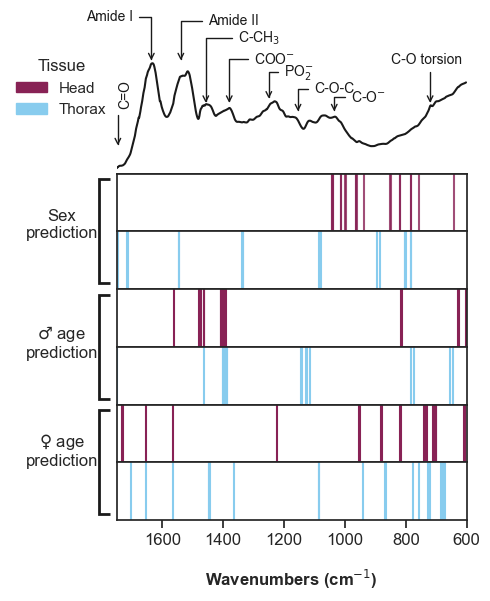

In [25]:
# final plot
import matplotlib.patches as mpatches

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )

color1 = "#88CCEE"
color2 = "#882255"

fig = plt.figure(layout=None,figsize=(5,6))
gs = fig.add_gridspec(nrows=8, ncols=1, left=0.05, right=0.75,
                      hspace=0, wspace=0.1)
ax0 = fig.add_subplot(gs[0:2, 0])
#ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])
ax4 = fig.add_subplot(gs[4,0])


ax6 = fig.add_subplot(gs[5,0])
ax7 = fig.add_subplot(gs[6,0])
ax8 = fig.add_subplot(gs[7,0])

ax0.plot(wavenumbers,np.mean(tsetse_head.loc[:,"1750":"602"],axis=0),color='k', linewidth=1.5)

ax5.plot(wavenumbers,np.mean(tsetse_thorax.loc[:,"1750":"602"],axis=0),color='k', linewidth=0.5)

for i in variable_importance_sex_head["Wavenumbers"]:
    ax2.axvline(i,color=color2,alpha=0.8)

for i in variable_importance_sex_thorax["Wavenumbers"]:
    ax3.axvline(i,color=color1)

for i in variable_importance_males_head["Wavenumbers"]:
    ax4.axvline(i, color=color2)

for i in [ax0,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    i.set_xlim(1750, 600)
    i.tick_params(left = False, right = False , labelleft = False)


for s in [ax0,ax5]:
    s.spines.right.set_visible(False)
    s.spines.top.set_visible(False)
    s.spines.left.set_visible(False)
    s.tick_params(bottom = False, labelbottom=False,labelleft=False)

for a in [ax2,ax3,ax4,ax6,ax7]:
    a.tick_params(bottom = False, labelbottom=False)
    a.tick_params(bottom = False, labelbottom=False)


for i in variable_importance_males_thorax["Wavenumbers"]:
    ax6.axvline(i,color=color1)

for i in variable_importance_females_head["Wavenumbers"]:
    ax7.axvline(i,color=color2)

for i in variable_importance_females_thorax["Wavenumbers"]:
    ax8.axvline(i,color=color1)


fontsize2=10
arrowprops2 = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=0",color='k',lw=1)

for i in [ax0,ax5]:
    i.annotate('Amide I',(1636, 0.3), xytext=(1850, 0.4), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('Amide II',(1539, 0.3), xytext=(1450, 0.39), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('C-CH$_{3}$',(1457, 0.2), xytext=(1350, 0.35), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('COO$^{-}$',(1380, 0.2), xytext=(1300, 0.3), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    #i.annotate('C-N',(1307, 0.2), xytext=(1300, 0.3), textcoords='data',#arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('PO$_{2}^{-}$',(1250, 0.21), xytext=(1200, 0.27), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('C-O-C',(1154, 0.18), xytext=(1100, 0.23), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k")


    i.annotate('C-O$^{-}$',(1035, 0.18), xytext=(980, 0.21), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k")


    i.annotate('C=O',(1746, 0.1), xytext=(1746, 0.2), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k",rotation=90)

    #i.annotate('-($CH_2$)-rock',
    #        xy=(800,0.2), xytext=(950, 0.3),xycoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('C-O torsion',
            xy=(720,0.2), xytext=(850, 0.3), xycoords='data',fontsize=fontsize2,color='k',arrowprops=arrowprops2)


fig.text(x=0.4,y=0, s='Wavenumbers (cm$^{-1}$)', horizontalalignment='center',fontweight='bold')

fig.text(x=-0.06,y=0.58, s='Sex\nprediction', horizontalalignment='center')
fig.text(x=-0.06,y=0.38, s='$\u2642$ age\nprediction', horizontalalignment='center')
fig.text(x=-0.06,y=0.2, s='$\u2640$ age\nprediction', horizontalalignment='center')

add_label_band(ax2, -0.9, 0.9, "")
add_label_band(ax4, -0.9, 0.9, "")
add_label_band(ax7, -0.9, 0.9, "")

# legend
head_patch = mpatches.Patch(color=color2, label='Head')
thorax_patch = mpatches.Patch(color=color1, label='Thorax')
plt.legend(handles=[head_patch,thorax_patch],title='Tissue',bbox_to_anchor=(0.01, 8.225),edgecolor='None')

plt.savefig('../results/plots/Fig9.tiff', dpi=350,bbox_inches="tight")

In [28]:
# Model parameters table

params_models = {"sex head": loaded_model_sex_head[1].get_params(),
                "sex thorax": loaded_model_females_thorax[1].get_params(),
                "female head": loaded_model_females_head[1].get_params(),
                "female thorax": loaded_model_females_thorax[1].get_params(),
                "male head": loaded_model_males_head[1].get_params(),
                "male thorax": loaded_model_males_thorax[1].get_params()}


In [31]:
params_modelsdf = pd.DataFrame(params_models)
#params_modelsdf.to_clipboard()

In [32]:
params_modelsdf

,sex head,sex thorax,female head,female thorax,male head,male thorax
C,100,100,10,100,1.0,100
class_weight,None,None,None,None,None,None
dual,False,False,False,False,False,False
fit_intercept,True,True,True,True,True,True
intercept_scaling,1,1,1,1,1,1
l1_ratio,None,None,None,None,None,None
max_iter,10000,10000,10000,10000,10000,10000
multi_class,auto,auto,auto,auto,auto,auto
n_jobs,None,None,None,None,None,None
penalty,l2,l2,l2,l2,l2,l2


In [80]:
mc_male_head_acc,mc_male_head_sens,mc_male_head_spec = montecarlo_crossvalidation(X_males_head,y_males_head,males_best_model_head,binary=True)

shuffle split: 100%|██████████| 500/500 [00:12<00:00, 39.64it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.83 ± 0.06


In [83]:
mc_sex_head_acc,mc_sex_head_sens,mc_sex_head_spec = montecarlo_crossvalidation(X_sex_head,y_sex_head,best_model_head,binary=True)

shuffle split:   0%|          | 0/500 [00:00<?, ?it/s]

shuffle split: 100%|██████████| 500/500 [00:54<00:00,  9.14it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.96 ± 0.02
